In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import ipywidgets as widgets

from matplotlib import pyplot as plt
from os import listdir, path, curdir
from os.path import isfile, join
from pathlib import Path
from tqdm import tqdm
from ipyfilechooser import FileChooser

import warnings
warnings.filterwarnings('ignore')

In [10]:
def generate_general_statistics(state, data, statistics):
    statistics['state'].append(state)
    statistics['polling_places'].append(len(data.groupby('id_polling_place')))
    statistics['n_cities'].append(len(data.groupby('NM_MUNICIPIO')))
    return statistics


def generate_precision_statistics(data, statistics):
    local_data = data[['precision', 'id_polling_place']].groupby('id_polling_place').first()
    n_precisions = local_data['precision'].value_counts()

    try:
        statistics['tse'].append(n_precisions['TSE'])
    except:
        statistics['tse'].append(0)

    try:
        statistics['rooftop'].append(n_precisions['ROOFTOP'])
    except:
        statistics['rooftop'].append(0)

    try:
        statistics['geometric_center'].append(n_precisions['GEOMETRIC_CENTER'])
    except:
        statistics['geometric_center'].append(0)

    try:
        statistics['range_interpolated'].append(
            n_precisions['RANGE_INTERPOLATED'])
    except:
        statistics['range_interpolated'].append(0)

    try:
        statistics['approximated'].append(n_precisions['APPROXIMATE'])
    except:
        statistics['approximated'].append(0)

    try:
        statistics['no_value'].append(n_precisions['NO_VALUE'])
    except:
        statistics['no_value'].append(0)
    return statistics


def generate_statistics(election_data,
                        area_filter='all',
                        precision_filter='all'):
    statistics = {
        'state': [],
        'polling_places': [],
        'n_cities': [],
        'tse': [],
        'rooftop': [],
        'geometric_center': [],
        'range_interpolated': [],
        'approximated': [],
        'no_value': []
    }

    for state, data in election_data:
        #filtering data by area
        if area_filter == 'Capital':
            data = data[data['capital'] == True]
        elif area_filter == 'Rural':
            data = data[data['rural'] == True]
        elif area_filter == 'Interior':
            data = data[data['capital']==False]
            data = data[data['rural']==False]

        #filtering data by precision
        if precision_filter == 'TSE':
            data = data[data['precision'] == 'TSE']
        elif precision_filter == 'Rooftop':
            data = data[data['precision'] == 'ROOFTOP']
        elif precision_filter == 'Range Interpolated':
            data = data[data['precision'] == 'RANGE_INTERPOLATED']

        #General statistics
        statistics = generate_general_statistics(state, data, statistics)
        #Precision statistics
        statistics = generate_precision_statistics(data, statistics)

    return pd.DataFrame(statistics)

In [13]:
def generate_polling_places_plot(
    election_statistics,
    field,
):

    election_statistics['%' + field] = 100 * election_statistics[
        field] / election_statistics[field].sum()
    fig, ax = plt.subplots(2, 1, figsize=(10, 5))
    fig.tight_layout()

    plot_electorate = sns.barplot(ax=ax[0],
                                  x='state',
                                  y=field,
                                  data=election_statistics,
                                  color='#59a2cb')
    if field == 'polling_places':
        title = "Polling Places"

    ax[0].title.set_text(title)
    ax[0].set(xlabel="", ylabel="Number of polling places")
    ax[0].set_xticks([])

    plot_electorate = sns.barplot(ax=ax[1],
                                  x='state',
                                  y='%' + field,
                                  data=election_statistics,
                                  color='#f85050')
    ax[1].set(xlabel="States", ylabel="Percentual of polling places (%)")

    #vals = ax[1].get_yticks()
    #ax[1].set_yticklabels(['{:.0}'.format(x) for x in vals])
    plt.subplots_adjust(hspace=0.01)
    return (fig)


def stacked_data(top_statistics,
                 bottom_statistics,
                 middle_statistics,
                 field='polling_places',
                 legend=['Capital', 'Rural', 'Interior']):
    #Set general plot properties
    #sns.set_style("white")
    sns.set_context({"figure.figsize": (30, 17)})

    #Plot 1 - background - "total" (top) series
    sns.barplot(x=top_statistics.state,
                y=top_statistics[field],
                color="#f85050")

    #Plot 2 - overlay - "middle" series
    series_to_plot = bottom_statistics[
        field] + middle_statistics[field]
    middle_plot = sns.barplot(x=middle_statistics.state,
                              y=series_to_plot,
                              color="#2b7c56")

    #Plot 3 - overlay - "bottom" series
    bottom_plot = sns.barplot(x=bottom_statistics.state,
                              y=bottom_statistics[field],
                              color="#59a2cb")

    topbar = plt.Rectangle((0, 0), 1, 1, fc="#f85050", edgecolor='none')
    bottombar = plt.Rectangle((0, 0), 1, 1, fc='#59a2cb', edgecolor='none')
    middlebar = plt.Rectangle((0, 0), 1, 1, fc='#2b7c56', edgecolor='none')

    l = plt.legend([bottombar, middlebar, topbar],
                   legend,
                   loc=1,
                   ncol=3,
                   prop={'size': 25})
    l.draw_frame(False)

    #Optional code - Make plot look nicer
    #sns.despine(left=True)
    bottom_plot.set_ylabel("Number of polling places")
    bottom_plot.set_xlabel("States")

    #Set fonts to consistent 16pt size
    for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
                 bottom_plot.get_xticklabels() +
                 bottom_plot.get_yticklabels()):
        item.set_fontsize(25)

# Step 1 - Load the data

<b>Select the folder where all electoral data are:</b>

In [4]:
# Create and display a FileChooser widget
ROOT_DIR = path.abspath(curdir)
fc = FileChooser(ROOT_DIR)
fc.use_dir_icons = True
#fc.title = '<b>Choose a folder</b>'

election_data = []
def load_data(chooser):
    global election_data
    
    selected_path = chooser.selected_path
    try:
        filenames = [
            filename for filename in listdir(selected_path)
            if isfile(join(selected_path, filename))
        ]

        for file in tqdm(filenames):
            data = pd.read_csv(selected_path + '\\' + file)
            state = file.split('.')[0]
            election_data = election_data + [(state, data)]
    except:
        print("An erro occur, please check the folder selected.")


# Register callback function
fc.register_callback(load_data)
display(fc)

FileChooser(path='C:\Users\Tiago\Documents\GitHub\Election_Forensics\notebooks\report', filename='', show_hidd…

100%|██████████████████████████████████████████| 27/27 [00:07<00:00,  3.51it/s]


# Step 2 - Filter the data

<b>Select the type of area to filter the data:</b>

In [15]:
dropdown_area = widgets.Dropdown(options=['All', 'Capital', 'Rural'])
output_polling_place_plot = widgets.Output()


def dropdown_area_eventhandler(change):
    output_polling_place_plot.clear_output()

    election_statistics = generate_statistics(election_data,
                                              area_filter=change.new)
    with output_polling_place_plot:
        plot = generate_polling_places_plot(election_statistics,
                                             field='polling_places')
        plt.show()
        plt.show()


dropdown_area.observe(dropdown_area_eventhandler, names='value')

display(dropdown_area)
#display(output_table)

Dropdown(options=('All', 'Capital', 'Rural'), value='All')

# <center> Data Visualization </center> 

## Polling places plot
This plot represents the size of the number of polling places per state. It is possible to change the plot by selecting specific areas. The percentages presented in this plot are calculated considering the sum of all states number of polling places for the type of area selected (All, Capital, or Rural). 

In [16]:
display(output_polling_place_plot)

Output()

## Polling places stacked plot (Areas)
This plot shows the composition of the polling places by areas (Interior, Capital, Rural)
PS: Run this cell after loading the data.

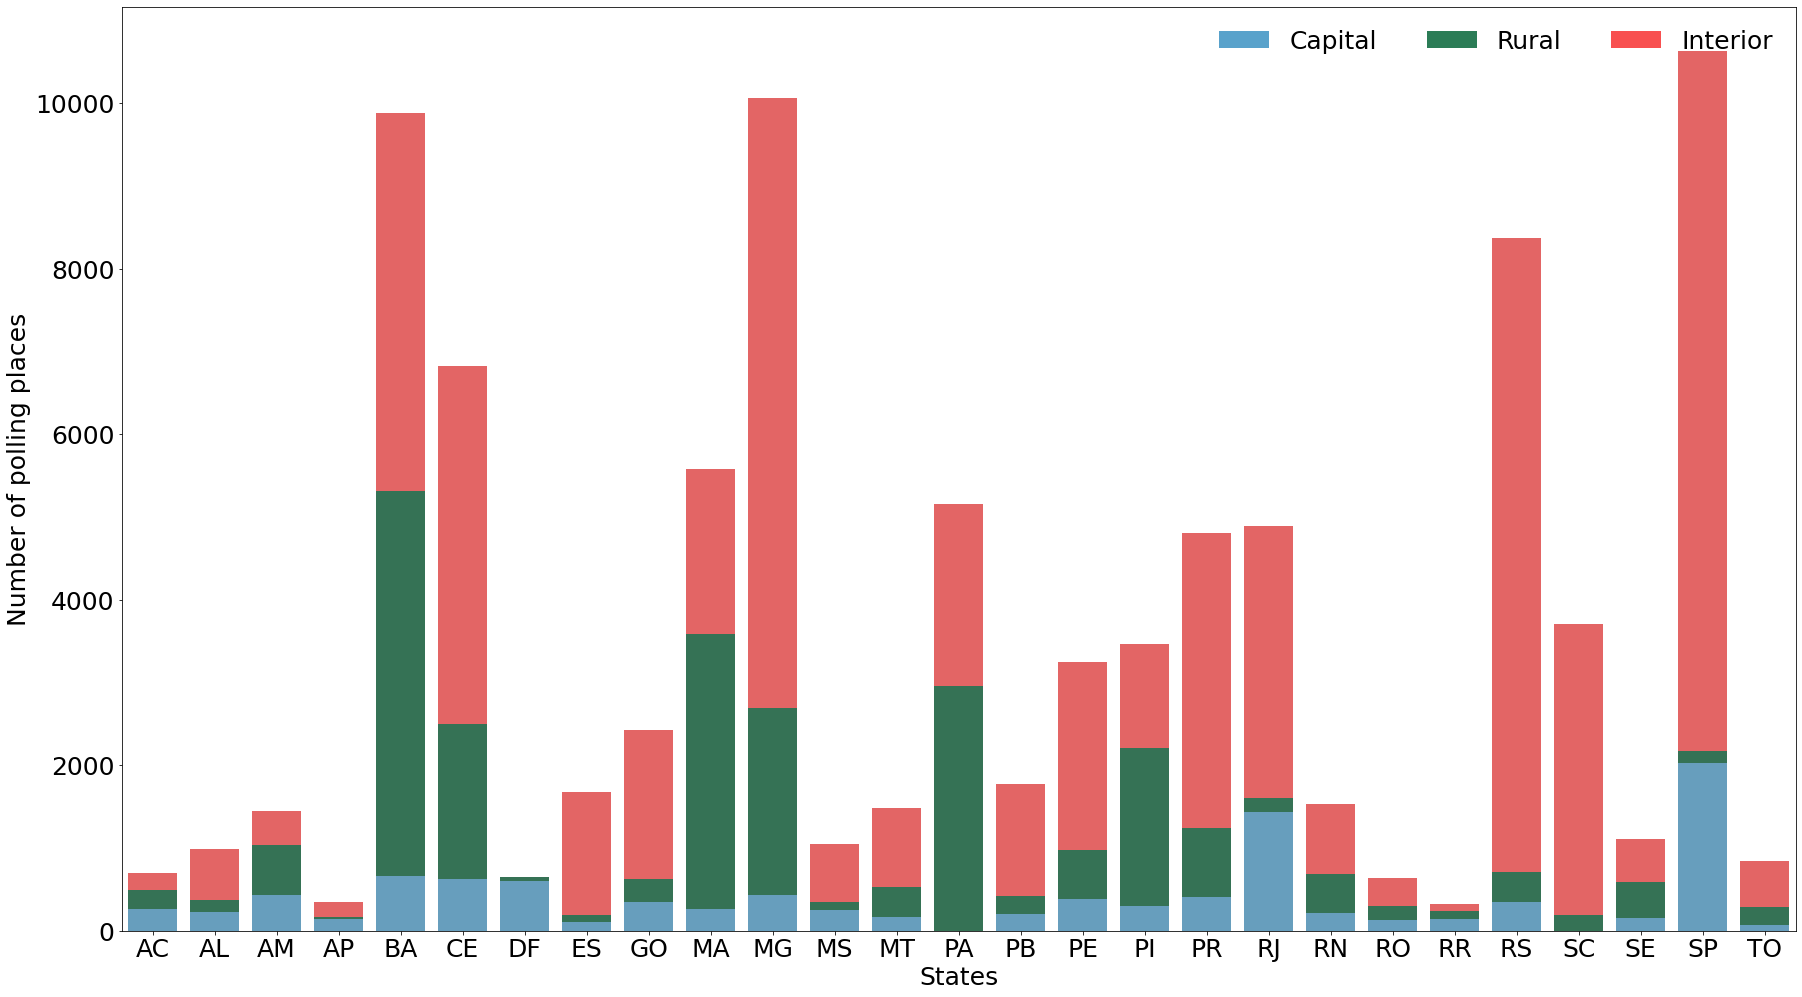

In [9]:
try:
    interior_statistics = generate_statistics(election_data, area_filter= 'All')
    capital_statistics = generate_statistics(election_data, area_filter= 'Capital')
    rural_statistics = generate_statistics(election_data, area_filter= 'Rural')

    stacked_data(interior_statistics, capital_statistics, rural_statistics)
except:
    print("An error occur, please check the selected folder.")

In [10]:
total_size = interior_statistics.polling_places.sum()
capital_size = capital_statistics.polling_places.sum()
rural_size = rural_statistics.polling_places.sum()
interior_size = total_size - capital_size - rural_size
print(
    "Polling places - Total: {}, Interior: {}, Capitals: {}, Rural: {}".format(
        total_size, interior_size, capital_size, rural_size))

interior_perc = 100 * interior_size / total_size
capital_perc = 100 * capital_size / total_size
rural_perc = 100 * rural_size / total_size
print("Polling places (%) - Interior:{}, Capitals:{}, Rural:{}".format(
    interior_perc, capital_perc, rural_perc))

Polling places - Total: 93580, Interior: 60502, Capitals: 10329, Rural: 22749
Polling places (%) - Interior:64.65270356913871, Capitals:11.037614874973285, Rural:24.30968155588801


## Polling places stacked plot (Precisions)

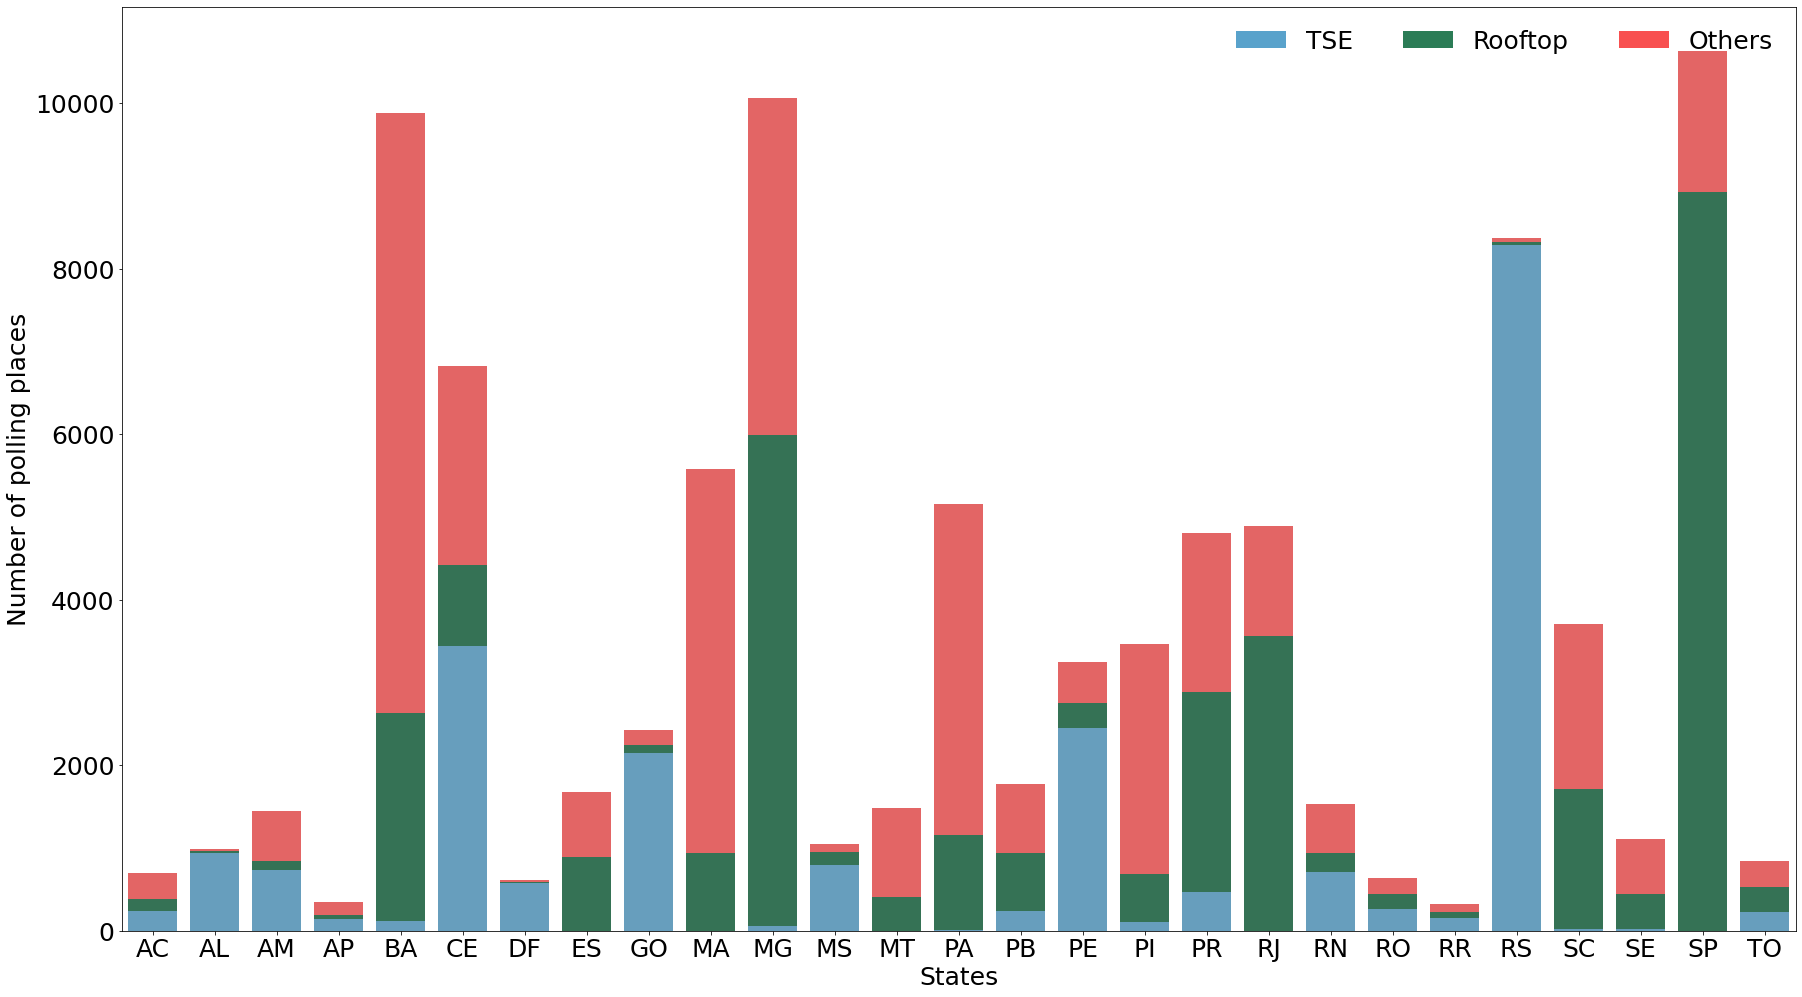

In [11]:
try:
    all_statistics = generate_statistics(election_data)
    tse_statistics = generate_statistics(election_data, precision_filter='TSE')
    rooftop_statistics = generate_statistics(election_data, precision_filter='Rooftop')

    stacked_data(all_statistics, tse_statistics, rooftop_statistics, legend=['TSE', 'Rooftop', 'Others'])
except:
    print("An error occur, please check the selected folder.")

In [12]:
total_size = all_statistics.polling_places.sum()
tse_size = tse_statistics.polling_places.sum()
rooftop_size = rooftop_statistics.polling_places.sum()
other_size = total_size - tse_size - rooftop_size
print(
    "Polling places - Total: {}, TSE: {}, Rooftop: {}, Others: {}".format(
        total_size, tse_size, rooftop_size, other_size))

other_perc = 100 * other_size / total_size
tse_perc = 100 * tse_size / total_size
rooftop_perc = 100 * rooftop_size / total_size
print("Polling places (%) - Others: {}, TSE: {}, Rooftop: {}".format(
    other_perc, tse_perc, rooftop_perc))

Polling places - Total: 93580, TSE: 22179, Rooftop: 32801, Others: 38600
Polling places (%) - Others: 41.248129942295364, TSE: 23.700577046377433, Rooftop: 35.0512930113272


## Capitals polling places stacked plot (Precisions)

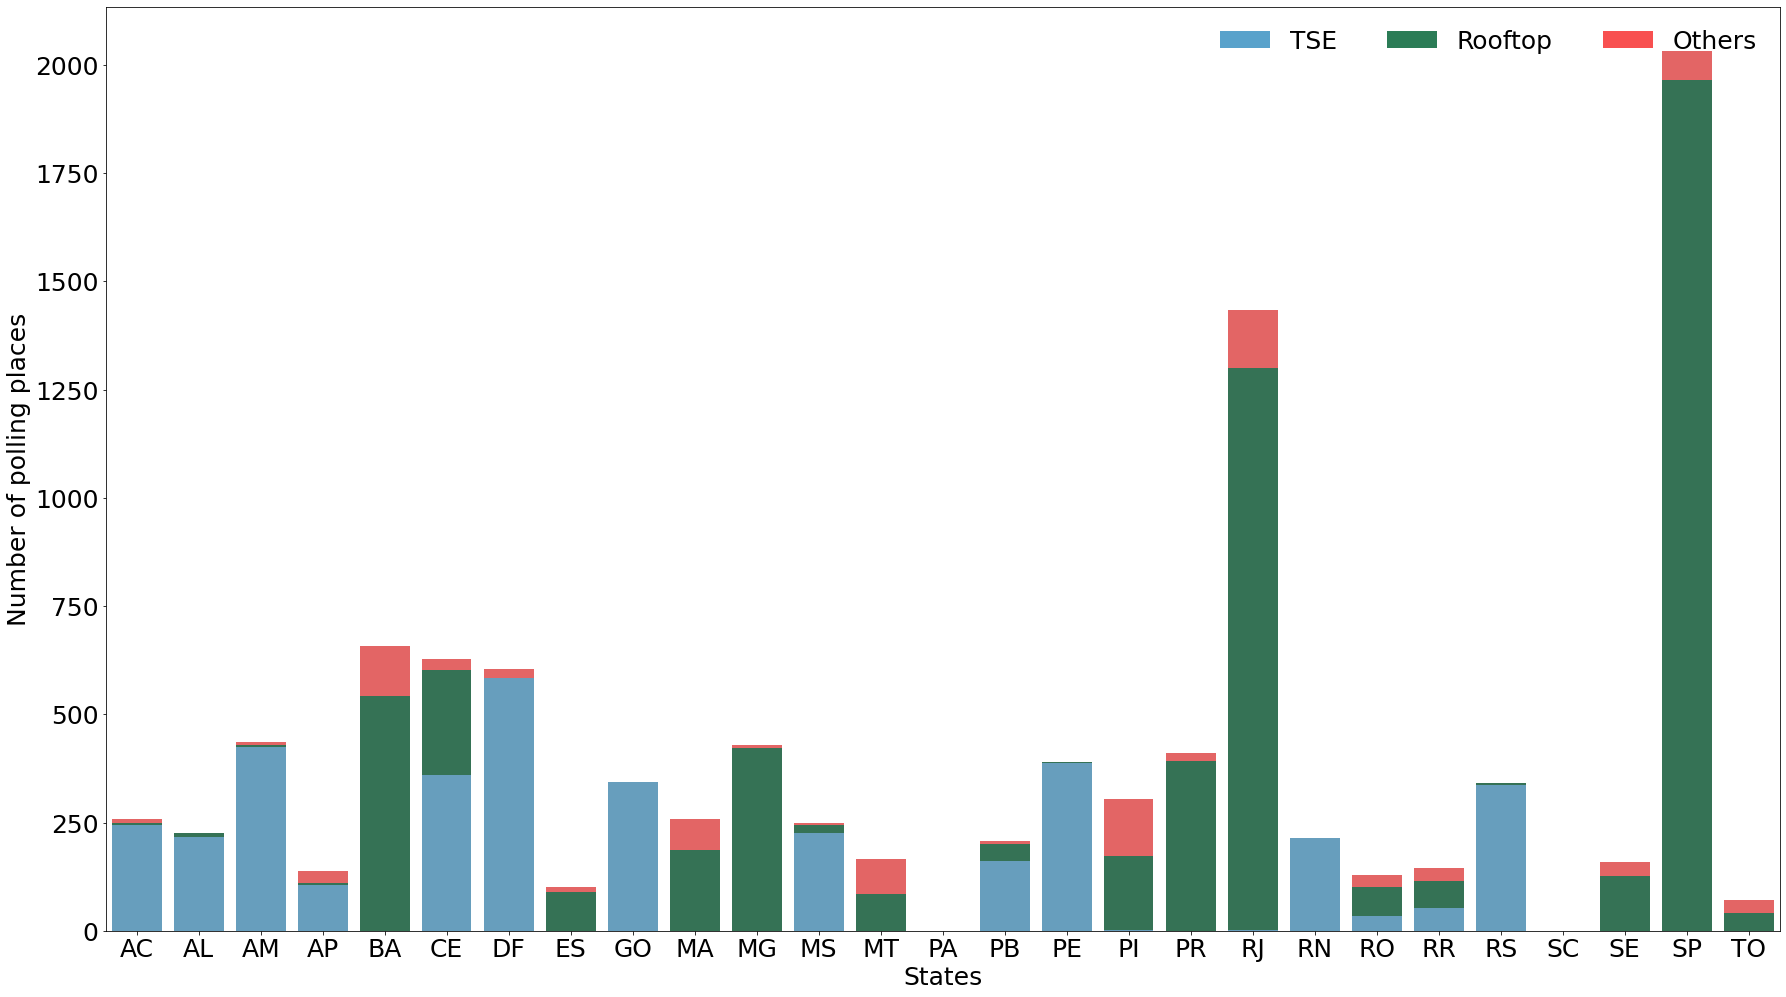

In [13]:
try:
    all_statistics = generate_statistics(election_data,
                                         area_filter='Capital',
                                         precision_filter='All')
    tse_statistics = generate_statistics(election_data,
                                         area_filter='Capital',
                                         precision_filter='TSE')
    rooftop_statistics = generate_statistics(election_data,
                                             area_filter='Capital',
                                             precision_filter='Rooftop')

    stacked_data(all_statistics,
                 tse_statistics,
                 rooftop_statistics,
                 legend=['TSE', 'Rooftop', 'Others'])
except:
    print("An error occur, please check the selected folder.")

In [14]:
total_size = all_statistics.polling_places.sum()
tse_size = tse_statistics.polling_places.sum()
rooftop_size = rooftop_statistics.polling_places.sum()
other_size = total_size - tse_size - rooftop_size
print(
    "Polling places - Total: {}, TSE: {}, Rooftop: {}, Others: {}".format(
        total_size, tse_size, rooftop_size, other_size))

other_perc = 100 * other_size / total_size
tse_perc = 100 * tse_size / total_size
rooftop_perc = 100 * rooftop_size / total_size
print("Polling places (%) - Others: {}, TSE: {}, Rooftop: {}".format(
    other_perc, tse_perc, rooftop_perc))

Polling places - Total: 10329, TSE: 3692, Rooftop: 5783, Others: 854
Polling places (%) - Others: 8.267983347855552, TSE: 35.7440216865137, Rooftop: 55.98799496563075


## Rural polling places stacked plot (Precisions)

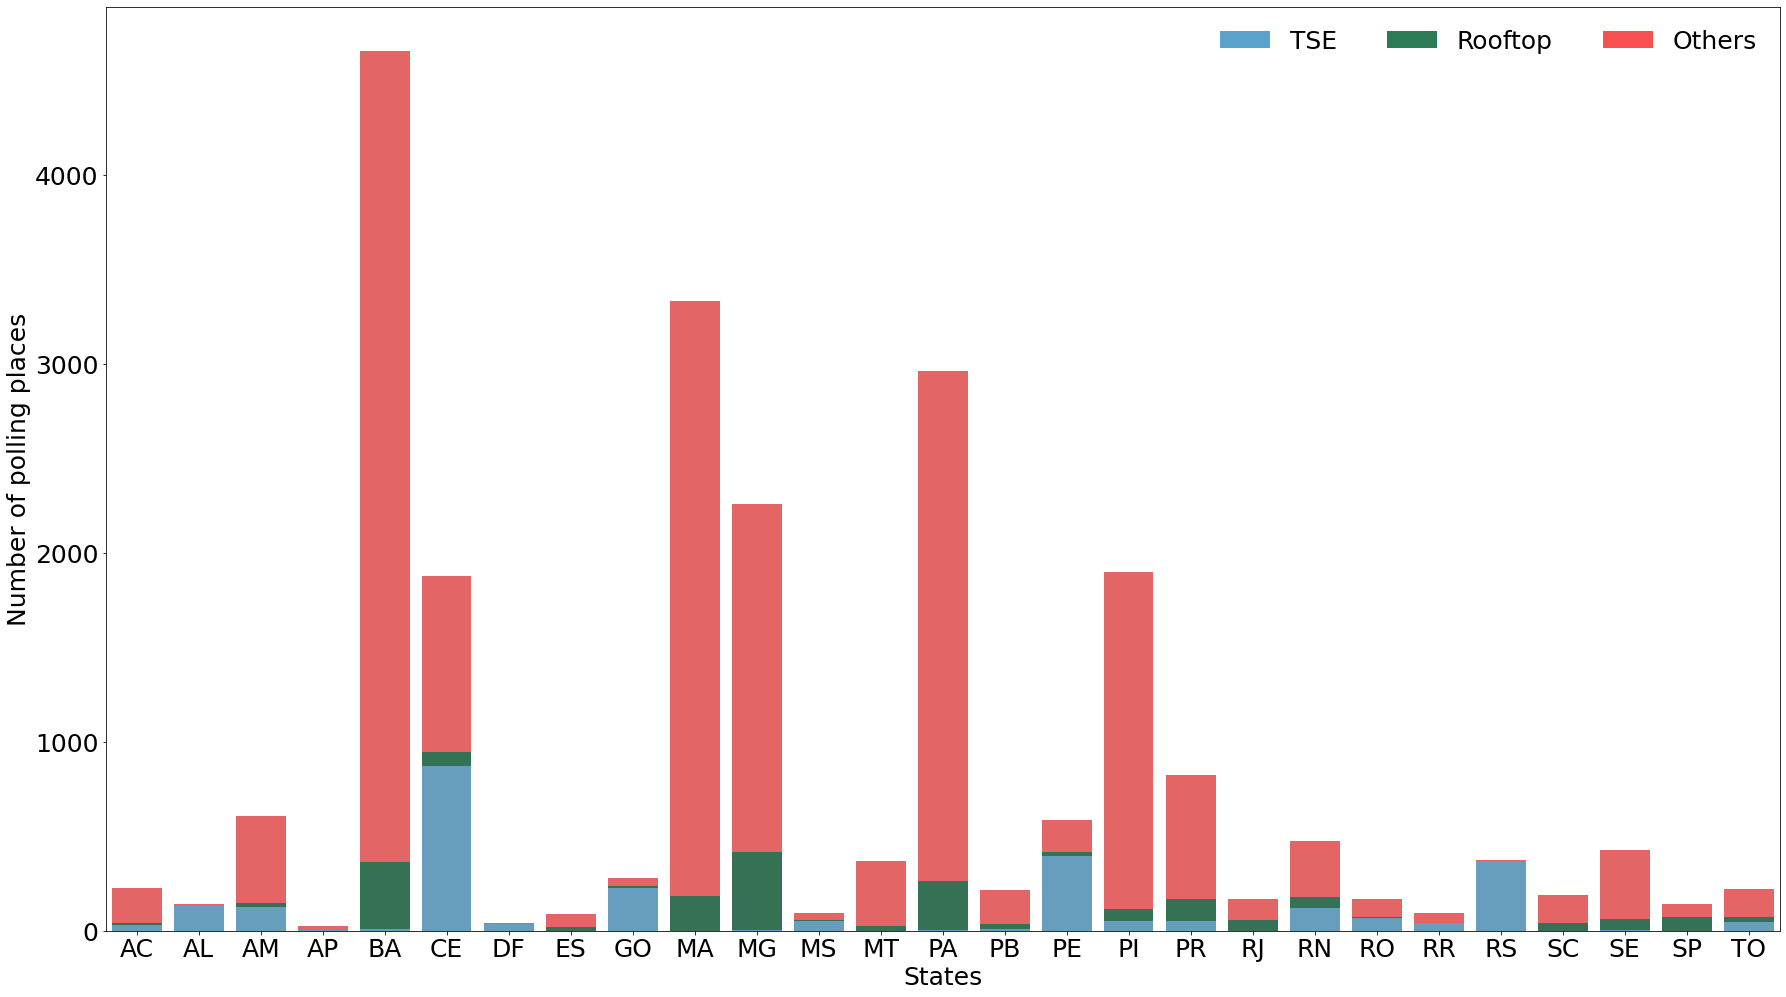

In [15]:
try:
    all_statistics = generate_statistics(election_data,
                                         area_filter='Rural',
                                         precision_filter='All')
    tse_statistics = generate_statistics(election_data,
                                         area_filter='Rural',
                                         precision_filter='TSE')
    rooftop_statistics = generate_statistics(election_data,
                                             area_filter='Rural',
                                             precision_filter='Rooftop')

    stacked_data(all_statistics,
                 tse_statistics,
                 rooftop_statistics,
                 legend=['TSE', 'Rooftop', 'Others'])
except:
    print("An error occur, please check the selected folder.")

In [65]:
total_size = all_statistics.polling_places.sum()
tse_size = tse_statistics.polling_places.sum()
rooftop_size = rooftop_statistics.polling_places.sum()
other_size = total_size - tse_size - rooftop_size
print(
    "Polling places - Total: {}, TSE: {}, Rooftop: {}, Others: {}".format(
        total_size, tse_size, rooftop_size, other_size))

other_perc = 100 * other_size / total_size
tse_perc = 100 * tse_size / total_size
rooftop_perc = 100 * rooftop_size / total_size
print("Polling places (%) - Others: {}, TSE: {}, Rooftop: {}".format(
    other_perc, tse_perc, rooftop_perc))

Polling places - Total: 22749, TSE: 2650, Rooftop: 1928, Others: 18171
Polling places (%) - Others: 79.87603850718713, TSE: 11.648863686315883, Rooftop: 8.475097806496988


## Interior polling places stacked plot (Precisions)

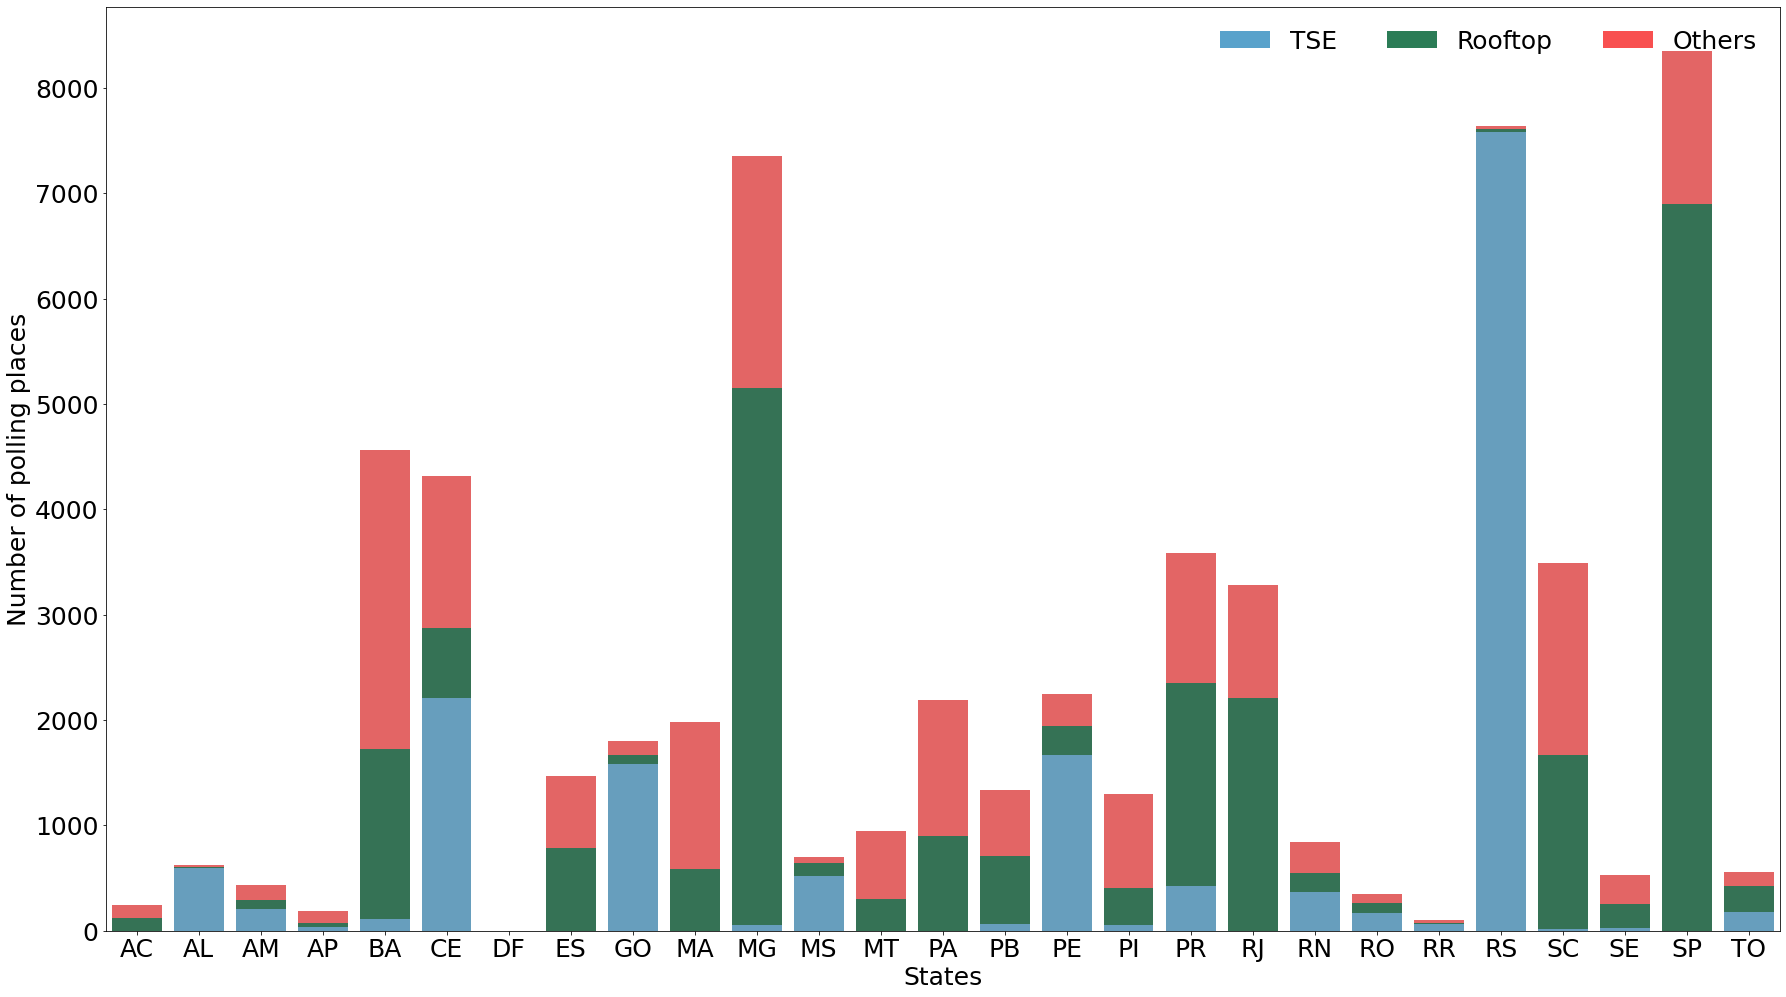

In [17]:
try:
    all_statistics = generate_statistics(election_data,
                                         area_filter='Interior',
                                         precision_filter='All')
    tse_statistics = generate_statistics(election_data,
                                         area_filter='Interior',
                                         precision_filter='TSE')
    rooftop_statistics = generate_statistics(election_data,
                                             area_filter='Interior',
                                             precision_filter='Rooftop')

    stacked_data(all_statistics,
                 tse_statistics,
                 rooftop_statistics,
                 legend=['TSE', 'Rooftop', 'Others'])
except:
    print("An error occur, please check the selected folder.")

# <center> Analysis </center>


The dataset presents almost 41% (38600) of the polling places with bad precision geocode. Most of them are concentrated in the interior (19246) and rural (18171) areas, with less than 2.5% (964) in the capitals. However, the interior and rural areas present 89% of the polling places and 76% of the electorate size, which makes them important places. The question that rises is how representative is the portion that is not well geocoded.